In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
from pathlib import Path
import json
import numpy as np

from config.config_types import AppConfig
from models import create_model
from pipeline.walkforward import WFCVGenerator
from utils.paths import CONFIG_DIR, SP500COPY_PATH, SP500_PATH, DATA_DIR, VOL_EXPERIMENTS_DIR, PRICE_EXPERIMENTS_DIR

DEVICE = "cuda"


In [2]:
import torch
import numpy as np
import json
import gc
from pathlib import Path

def _infer_lstm_input_size_from_ckpt(state_dict: dict) -> int | None:
    """
    Efficiently finds LSTM input size from weights without hardcoded layer names.
    searches for any parameter ending in 'weight_ih_l0' (input-hidden weights of layer 0).
    """
    # Use a generator to find the first match without iterating the whole dict twice
    for k, v in state_dict.items():
        if "weight_ih_l0" in k: # Standard PyTorch LSTM parameter naming
            # shape is [4 * Hidden, Input_Size]
            return int(v.shape[1])
    return None

def _get_data_dims(X_sample: torch.Tensor | np.ndarray):
    """Normalized extractor for T (time) and D (features)."""
    shape = X_sample.shape
    if len(shape) == 2: # (N, T) -> Univariate
        return shape[1], 1
    elif len(shape) == 3: # (N, T, D) -> Multivariate
        return shape[1], shape[2]
    else:
        raise ValueError(f"Unexpected data shape: {shape}. Expected (N, T) or (N, T, D).")

def _make_input_shape_for_eval(cfg, X_sample, state_dict):
    name = cfg.model.name.lower()
    T, D_data = _get_data_dims(X_sample)

    if name in ["lstm", "transformer", "gru"]:
        # Try to trust the checkpoint's reality over the data's shape
        D_ckpt = _infer_lstm_input_size_from_ckpt(state_dict)
        D = D_ckpt if D_ckpt is not None else D_data
        
        # Guardrail: Warn if mismatch
        if D_ckpt is not None and D_ckpt != D_data:
            print(f"Warning: Data feature dim ({D_data}) != Model checkpoint dim ({D_ckpt}). Using Checkpoint dim.")
        
        return (T, D)
        
    elif name == "simplecnn":
        return (1, T) # (Channels, Length)
        
    elif name == "mlp":
        return (T * D_data,) # Flattened
        
    else:
        # Fallback or strict error
        raise ValueError(f"Unknown model name for shape inference: {name}")

def load_nn(base_path, X_test, fold_idx=0, device='cuda'):
    """
    Loads model safely by staging weights on CPU to avoid VRAM fragmentation.
    """
    base_path = Path(base_path)
    
    # 1. Load Config
    cfg_path = base_path / "config_snapshot.json"
    if not cfg_path.exists():
        # Fallback for some directory structures
        cfg_path = base_path / "config.json" 
    
    if not cfg_path.exists():
        raise FileNotFoundError(f"Config not found in {base_path}")
        
    cfg_json = json.loads(cfg_path.read_text())
    cfg = AppConfig.from_dict(cfg_json["cfg"])
    lr = cfg.trainer.hparams.get('lr')
    print(f'lr: {lr:.6f}')

    # 2. Path Validation
    ckpt_path = base_path / f"fold_{fold_idx:03d}" / "model_best.pt"
    if not ckpt_path.exists():
        return None

    # 3. Memory-Safe Load (The Fix for OOM)
    # map_location='cpu' ensures we don't spike VRAM loading optimizer states
    checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=False)
    
    # Handle both full checkpoints and weight-only saves
    if "model_state" in checkpoint:
        raw_state = checkpoint["model_state"]
    elif "state_dict" in checkpoint:
        raw_state = checkpoint["state_dict"]
    else:
        raw_state = checkpoint # Assume it is just the weights

    # Clean keys (remove torch.compile prefixes)
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in raw_state.items()}
    
    # 4. Infer Shapes using the cleaner dictionary
    input_shape = _make_input_shape_for_eval(cfg, X_test, state_dict)
    
    # Handle Walkforward config optionally
    lookback = getattr(cfg.walkforward, 'lookback', None)
    output_shape = lookback + 1 if lookback is not None else 1

    # 5. Critical Cleanup
    # Delete the full checkpoint (which might hold Optimizer state) BEFORE model creation
    del checkpoint
    del raw_state
    gc.collect()

    # 6. Model Creation & Loading
    # Create model on CPU first (default)
    model = create_model(cfg.model, input_shape, output_shape)
    
    # Load weights (Strict checking ensures architecture matches weights)
    try:
        model.load_state_dict(state_dict, strict=True)
    except RuntimeError as e:
        print(f"Strict loading failed for {base_path.name}. Retrying with strict=False.")
        model.load_state_dict(state_dict, strict=False)

    
    return model, lr

In [3]:
import torch
import numpy as np
import gc

def estimate_lambda_max_optimized(model, criterion, batch_tuple, n_iter=50, batch_size=32, device='cuda', tol=1e-3):
    """
    Optimized Power Iteration for Lambda Max.
    Handles memory aggressively to prevent OOM on LSTMs.
    """
    # 1. Setup & Memory Prep
    torch.cuda.empty_cache()
    model.eval()
    model.to(device)
    
    # 2. Efficient Data Loading & Slicing
    # CRITICAL: Slice BEFORE moving to GPU to save memory
    inputs_raw, targets_raw = batch_tuple
    
    if len(inputs_raw) > batch_size:
        inputs_raw = inputs_raw[:batch_size]
        targets_raw = targets_raw[:batch_size]

    # Robust Conversion (Numpy -> Tensor -> Float -> Device)
    if isinstance(inputs_raw, np.ndarray):
        inputs = torch.from_numpy(inputs_raw)
    else:
        inputs = inputs_raw
        
    if isinstance(targets_raw, np.ndarray):
        targets = torch.from_numpy(targets_raw)
    else:
        targets = targets_raw

    inputs = inputs.float().to(device)
    targets = targets.float().to(device)

    # 3. Initialize Eigenvector Estimate (v)
    params = [p for p in model.parameters() if p.requires_grad]
    v = [torch.randn_like(p) for p in params]
    
    # Normalize v
    v_norm = torch.sqrt(sum(torch.sum(x * x) for x in v))
    v = [x / v_norm for x in v]

    current_lambda = 0.0
    
    try:
        for i in range(n_iter):
            model.zero_grad()
            
            # --- HVP Step ---            
            # A. Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # B. First Backward
            grads = torch.autograd.grad(loss, params, create_graph=True, only_inputs=True)
            
            # C. Gradient-Vector Product
            grad_v_prod = sum(torch.sum(g * x) for g, x in zip(grads, v))
            
            # D. Second Backward (H*v)
            Hv = torch.autograd.grad(grad_v_prod, params, retain_graph=False, only_inputs=True)
            
            # --- Power Iteration Update ---
            hv_norm = torch.sqrt(sum(torch.sum(x * x) for x in Hv))
            v = [x / hv_norm for x in Hv]
            
            # Convergence Check
            prev_lambda = current_lambda
            current_lambda = hv_norm.item()
            
            if i > 0 and abs(current_lambda - prev_lambda) < tol:
                break

            # CRITICAL: Delete graph variables immediately to free VRAM for next iter
            del loss, outputs, grads, grad_v_prod, Hv
            
    finally:
        # 4. Aggressive Cleanup
        # Ensure we don't leave massive tensors hanging if the loop crashes
        del inputs, targets, v, params
        if 'loss' in locals(): del loss
        if 'outputs' in locals(): del outputs
        if 'grads' in locals(): del grads
        
        # Force Python GC and PyTorch Cache Clear
        gc.collect()
        torch.cuda.empty_cache()

    return current_lambda

In [4]:

cfg_mlp = AppConfig.from_dict(f"{CONFIG_DIR}/vol_mlp.yaml")
cfg_cnn = AppConfig.from_dict(f"{CONFIG_DIR}/vol_cnn.yaml")
cfg_lstm = AppConfig.from_dict(f"{CONFIG_DIR}/vol_lstm.yaml")
cfg_transformer = AppConfig.from_dict(f"{CONFIG_DIR}/vol_transformer.yaml")

wf = WFCVGenerator(cfg_lstm.walkforward)


In [5]:
data = {}



for i, fold_data in enumerate(wf.folds()):
    size = fold_data[4]
    y_test = fold_data[5]

    data[i] = fold_data
    print(i)
    #if i == fold_num:
    #    break

use = data[0]


Xtr             = use[0]
ytr             = use[1]
Xv              = use[2]
yv              = use[3]
Xte             = use[4]
yte             = use[5]
Xtr_val         = use[6]
ytr_val         = use[7]
Xte_merged      = use[8]
yte_merged      = use[9]
id_tr           = use[10]
id_v            = use[11]
id_te           = use[12]
window_train    = use[13]
window_val      = use[14]
window_test     = use[15]
X_scaler        = use[16]
y_scaler        = use[17]
X_scaler_merged = use[18]
y_scaler_merged = use[19]


0


In [6]:
num_data = 2**16
batch = (Xtr[:num_data], ytr[:num_data])

In [7]:
import sys
import gc
import torch

def clean_gpu():
    # 1. Delete the model variable if it exists
    if 'model' in globals():
        del globals()['model']
    
    # 2. Clear Hidden References (The "Jupyter Trap")
    # Jupyter stores the last error in these variables. 
    # If your OOM error holds the stack frame, it holds the model.
    if hasattr(sys, 'last_traceback'):
        del sys.last_traceback
    if hasattr(sys, 'last_value'):
        del sys.last_value
    if hasattr(sys, 'last_type'):
        del sys.last_type

    # 3. Clear Loop Variables
    # If you crashed inside a loop, 'b' or 'batch' might still hold refs
    if 'inputs' in globals(): del globals()['inputs']
    if 'targets' in globals(): del globals()['targets']
    if 'grads' in globals(): del globals()['grads']

    # 4. Force Garbage Collection
    gc.collect()
    
    # 5. Clear PyTorch Cache
    torch.cuda.empty_cache()
    

clean_gpu()

In [8]:
def extract_model_optim(path):
    # 1. Isolate the directory name starting with 'exp_'
    # We strip '/' to handle trailing slashes safely
    parts = path.strip('/').split('/')
    exp_dir = next((p for p in parts if p.startswith('exp_')), None)
    
    if not exp_dir:
        return None
    
    # 2. Split the experiment name by underscore
    # Structure: exp_{id}_{arch}_{size}_{optim}_{extra...}
    # Indices:    0    1     2      3      4
    tokens = exp_dir.split('_')
    
    # 3. Combine Arch (2) and Optim (4)
    if len(tokens) >= 5:
        return f"{tokens[2]}_{tokens[4]}"
    return None

# --- usage ---
# Output: 'transformer_sgd'

In [9]:
base_dirs = [
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_169_cnn_100_muon_icml_3/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_037_cnn_100_adam_lr/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_041_cnn_100_sgd/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_035_mlp_100_muon_lr/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_038_mlp_100_adam_lr/trial_search_best/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_043_mlp_100_sgd/trial_search_best/'
 
 ]
criterion = torch.nn.MSELoss()

exp = [ 
# '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_037_cnn_100_adam_lr/',
 '/orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_041_cnn_100_sgd/',
]

#dirs = []
#
#for e in exp:
#    new = os.listdir(e)
#    new = [f'{e}{n}/' for n in new]
#    dirs = dirs + new


results = {}

for i, b in enumerate(base_dirs):
    # Load
    res = load_nn(b, batch[0])
    if res is None: continue
        
    try:
        model, lr = res
        # Run optimized estimation
        # Note: We pass batch_size=32 explicitly here
        l_max = estimate_lambda_max_optimized(
            model, 
            criterion, 
            batch, 
            n_iter=50, 
            batch_size=65536 # Reduces VRAM usage drastically
        )
        print(f"{extract_model_optim(b)} | Lambda Max: {l_max}")

        results[f'{extract_model_optim(b)}_{i}'] = [l_max, lr, 2/lr]
        
    except RuntimeError as e:
        print(f"Skipping {b} due to error: {e}")
        
    finally:
        # Delete model and clear cache between runs
        del model
        gc.collect()
        torch.cuda.empty_cache()

    

lr: 0.000020
Skipping /orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_169_cnn_100_muon_icml_3/trial_search_best/ due to error: CUDA out of memory. Tried to allocate 2.81 GiB. GPU 0 has a total capacity of 44.39 GiB of which 1.62 GiB is free. Including non-PyTorch memory, this process has 42.76 GiB memory in use. Of the allocated memory 42.09 GiB is allocated by PyTorch, and 171.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
lr: 0.000192
Skipping /orcd/home/002/corte911/code/finNN_code/src/volatility/experiments/exp_037_cnn_100_adam_lr/trial_search_best/ due to error: CUDA out of memory. Tried to allocate 2.81 GiB. GPU 0 has a total capacity of 44.39 GiB of which 2.74 GiB is free. Including non-PyTorch memory, this process ha

KeyboardInterrupt: 

[[29.019174575805664, 0.037460266483547784], [2.0, 0.09507192349792752], [483.45721435546875, 0.0598698618348617], [135.62551879882812, 0.01561030385783923], [167.1968536376953, 0.005817780380698264], [197.32769775390625, 0.0016569240731254473], [186.20127868652344, 0.00019243322503857425], [235.60159301757812, 0.0007646564584361526], [227.4149169921875, 0.0005422825506204813], [239.9461669921875, 0.00019243322503857425]]


Text(0.5, 1.0, 'CNN Adam Runs')

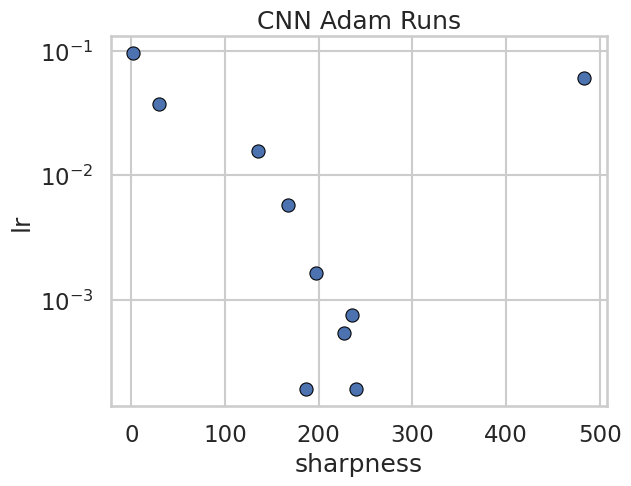

In [49]:
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")
sns.set_palette("dark")


sub = [v for k,v in results.items() if 'cnn_adam' in k]
sub = [s for s in sub if not (s[0] >= 1000 or s[1] >= 0.2)]


print(sub)

df = pd.DataFrame(sub, columns=["sharpness", "lr"])

sns.set_theme(style="whitegrid", context="talk")

ax = sns.scatterplot(
    data=df,
    x="sharpness",
    y="lr",
    s=90,
    edgecolor="black",
    # log_scale=(False, True)  <-- DELETE THIS LINE
)

# Set the log scale explicitly here
ax.set_yscale("log") 
# ax.set_xscale("log") # If you wanted both

ax.set_title("CNN Adam Runs")
#plt.tight_layout()
#plt.show()

[[2.0014021396636963, 0.09507192349792752], [2.0297539234161377, 0.0598698618348617], [75.46121215820312, 0.08661895281603578], [68.93052673339844, 0.09699128611767782], [68.98230743408203, 0.09846267508453047], [90.10853576660156, 0.06828384226167375], [67.41011047363281, 0.09740766009469327], [51.52719497680664, 0.09846267508453047]]


Text(0.5, 1.0, 'CNN SGD Runs')

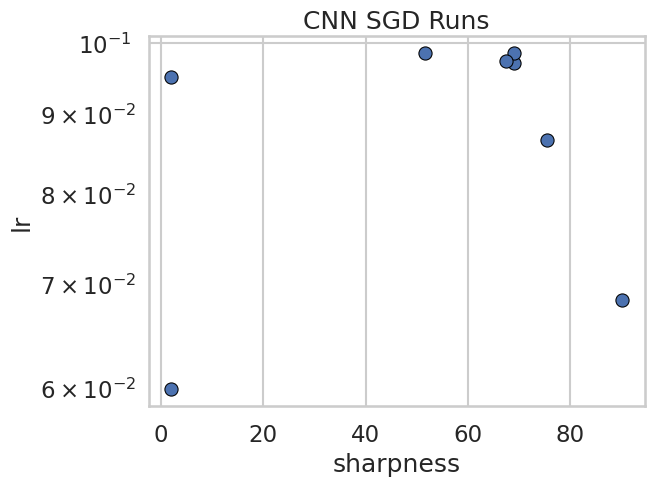

In [52]:
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")
sns.set_palette("dark")


sub = [v for k,v in results.items() if 'cnn_sgd' in k]
sub = [s for s in sub if not (s[0] >= 100 or s[1] >= 0.2)]


print(sub)

df = pd.DataFrame(sub, columns=["sharpness", "lr"])

sns.set_theme(style="whitegrid", context="talk")

ax = sns.scatterplot(
    data=df,
    x="sharpness",
    y="lr",
    s=90,
    edgecolor="black",
)

# Set the log scale explicitly here
ax.set_yscale("log") 
# ax.set_xscale("log") # If you wanted both

ax.set_title("CNN SGD Runs")
#plt.tight_layout()
#plt.show()

In [31]:
from utils.inference_utils import format_legend_name

format_legend_name("exp_035_mlp_100_muon_lr").lower().replace(' lr', '').replace(' ', '_')


'mlp_100_muon'